# Visu EEG data

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np 
import csv 
import pandas as pd
from pathlib import Path
from omegaconf import OmegaConf

from pytorch_lightning import Trainer
import pytorch_lightning as pl
from datetime import datetime
import os
import pandas as pd
import einops
import torch
import mne

# from contrib.eeg.models_directinv import HeckerLSTM, HeckerLSTMpl
# from contrib.eeg.models import CosineReshape, Cosine 
from contrib.eeg.data import EsiDatamodule, EsiDataset

from contrib.eeg.utils_eeg import plot_source_estimate, plot_src_from_imgs

from contrib.eeg.utils_eeg import load_fwd, load_mne_info
from functools import partial
from torch import nn
# from contrib.eeg.model_short import EsiBaseObsCost, RearrangedConvLstmGradModel, optim_adam_gradphi, EsiGradSolver, ESILitModule, ConvAEPrior

In [2]:
pl.seed_everything(333)

Seed set to 333


333

In [3]:
datamodule_config_path = Path(
    "config", "dataset", "test_dataset.yaml"
)

# datamodule_config_path = Path(
#     "config", "dataset", "ses_sereega_fsav994_125ms.yaml"
# )
print(datamodule_config_path)

config/dataset/test_dataset.yaml


In [4]:
data_conf = OmegaConf.load(datamodule_config_path)
config_file = Path(
                data_conf.datafolder, 
                data_conf.subject_name, data_conf.orientation, data_conf.electrode_montage, data_conf.source_sampling, "simu",
                data_conf.simu_name, f"{data_conf.simu_name}{data_conf.source_sampling}_config.json"
)        
data_conf.update({'config_file': config_file})

datamodule_conf = {
    "dataset_kw": 
    {
        "datafolder":data_conf.datafolder, 
        "simu_name": data_conf.simu_name,
        "subject_name": data_conf.subject_name,
        "source_sampling": data_conf.source_sampling,
        "electrode_montage": data_conf.electrode_montage,
        "orientation": data_conf.orientation,
        "to_load": data_conf.to_load,
        "snr_db": 5,
        "noise_type": {"white":1.},
        "scaler_type": 'linear_bis',
        "replace_root": True
    },
    "subset_name": "left_back",
    "dl_kw":{
        "batch_size": 16
    }
}
head_model_dict = {
    'subject_name': data_conf.subject_name,
    'orientation': data_conf.orientation,
    'electrode_montage': data_conf.electrode_montage,
    'source_sampling': data_conf.source_sampling,
}

In [5]:
dm = EsiDatamodule(**datamodule_conf)
dm.setup('train')
batch = next(iter(dm.train_dataloader()))

--- only 255 available ---


Text(0.5, 1.0, 'Output: Source activity')

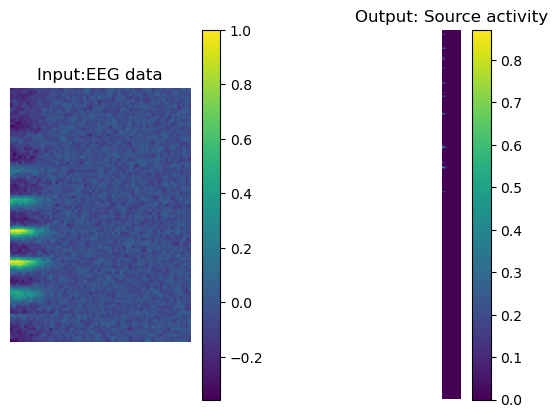

In [6]:
k=1
## visu data
plt.figure()
plt.subplot(121)
plt.imshow(batch.input[k,:,:].squeeze().numpy())
plt.colorbar()
plt.axis('off')
plt.title('Input:EEG data')
plt.subplot(122)
plt.imshow(batch.tgt[k,:,:].squeeze().numpy())
plt.axis('off')
plt.colorbar()
plt.title('Output: Source activity')

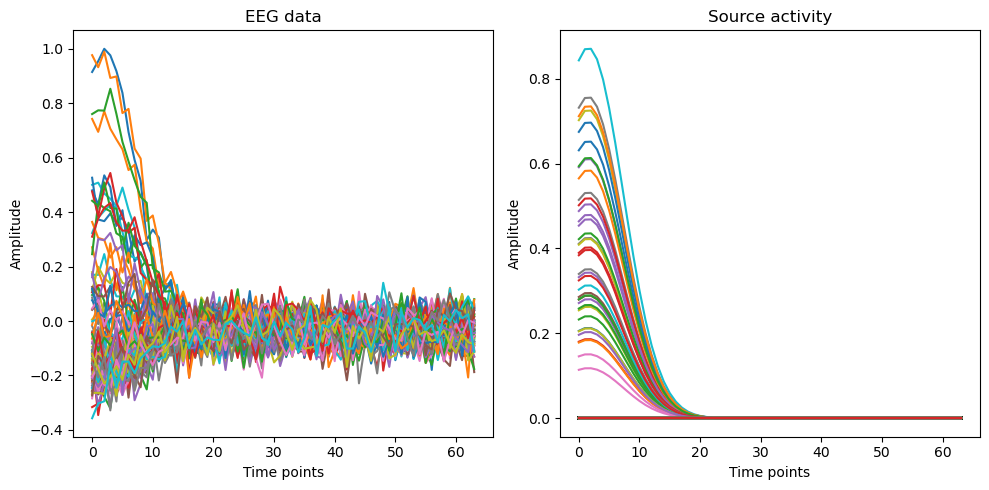

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(121)
for e in range(data_conf.n_electrodes):
    plt.plot(batch.input[k,e,:].squeeze().numpy())
plt.xlabel('Time points')
plt.ylabel('Amplitude')
plt.title('EEG data')

plt.subplot(122)
for s in range(data_conf.n_sources): 
    plt.plot(batch.tgt[k,s,:].squeeze().numpy())
plt.xlabel('Time points')
plt.ylabel('Amplitude')
plt.title('Source activity')
plt.tight_layout()

# Regularization 


In [8]:
fwd = load_fwd( datafolder=data_conf.datafolder, head_model_dict=head_model_dict, fwd_name='fwd_ico3-fwd.fif', scaler_type="linear_bis" )
idx = 1
t_max = np.argmax( batch.tgt[idx,:,:].squeeze().abs().sum(0).numpy() )

Reading forward solution from /home/triet/Documents/DATA/fsaverage/constrained/standard_1020/ico3/model/fwd_ico3-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (1284 sources, 90 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
NORMALIZATION LEADFIELD: linear_bis


In [9]:
import yaml
#def plot_source_estimate(src, t_max, fwd, surfer_view="lateral", fs=512, threshold=0.2):    
surfer_params_file = "params_surfer.yaml"
with open(surfer_params_file, "r") as f:
    surfer_kwargs = yaml.safe_load(f)


src=batch.tgt[idx,:,:]
threshold = 0.2
fs=512
surfer_view="lateral"

j_plot = src[:, t_max]
if j_plot.max() != 0 : 
    j_plot = j_plot / np.abs(j_plot).max()

stc_plot = mne.SourceEstimate(
    data=j_plot,
    vertices=[
        fwd["src"][0]["vertno"],
        fwd["src"][1]["vertno"],
    ],
    tmin=0.0,
    tstep=1 / fs,
    subject="fsaverage",
)
surfer_kwargs["clim"] = dict(
    kind="value",
    lims=[0, threshold * stc_plot.data.max(), stc_plot.data.max()],
)
surfer_kwargs["colorbar"] = False
surfer_kwargs["views"] = surfer_view

brain = stc_plot.plot(**surfer_kwargs)
img = brain.screenshot()
brain.close()

Using pyvistaqt 3d backend.

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


In [16]:
surfer_kwargs

{'subject': 'fsaverage',
 'hemi': 'lh',
 'views': 'lateral',
 'surface': 'white',
 'time_viewer': False,
 'alpha': 0.8,
 'smoothing_steps': 30,
 'background': 'white',
 'colormap': 'Reds',
 'clim': {'kind': 'value', 'lims': [0, tensor(0.2000), tensor(1.)]},
 'add_data_kwargs': {'colorbar_kwargs': {'n_labels': 5,
   'label_font_size': 20,
   'width': 0.05,
   'height': 0.8,
   'vertical': True,
   'position_x': 0.0,
   'position_y': 0.0}},
 'brain_kwargs': {'offscreen': False},
 'colorbar': False}